In [33]:
from data_util import precompute_ar_covariates
from twarhmm import TWARHMM, LinearRegressionObservations
import matplotlib.pyplot as plt
from util import random_rotation
import numpy as np
from scipy.linalg import logm

In [34]:
# we'll generate some 2D autoregressive (1 lag) data
data_dim = 2
num_lags = 1

# dictionary setting the parameters of the model
true_config =  dict(
    num_discrete_states=2,
    data_dim=data_dim,
    covariates_dim=3,
    tau_scale=0.7,
    num_taus=3,
    kappa=5000,
    alpha=2,
    covariance_reg=1e-4)

In [35]:
# initialize model using the above dictionary
true_model = TWARHMM(true_config)

# set transition matrices manually (don't have to do this)
z_stay = .99
transition_z = z_stay*np.eye(true_config['num_discrete_states']) + (1-z_stay)/(true_config['num_discrete_states']-1)*(np.ones((true_config['num_discrete_states'],true_config['num_discrete_states']))-np.eye(true_config['num_discrete_states']))
tau_stay = 0.95
transition_tau = tau_stay*np.eye(true_config['num_taus']) + (1-tau_stay)/(true_config['num_taus']-1)*(np.ones((true_config['num_taus'],true_config['num_taus']))-np.eye(true_config['num_taus']))
true_model.transitions.transition_matrix = (transition_z, transition_tau)

# set weight matrices manually (note that each matrix has an additional column associated with the bias (constant) term)
true_model.observations.weights[0,:,:-1] = logm(0.92*random_rotation(data_dim,-np.pi/20))
true_model.observations.weights[1,:,:-1] = logm(0.92*random_rotation(data_dim,np.pi/20))
true_model.observations.weights[0,:,-1] = np.array([1,0])
true_model.observations.weights[1,:,-1] = np.array([-1,0])

In [36]:
# set the number of timesteps of data you'd like to generate
T = 30000
# sample for T timesteps, and give bias=True because the weight matrices have the additional bias column
z,x = true_model.sample(T, bias=True)
# also grab some test data
z2,x2 = true_model.sample(T, bias=True)

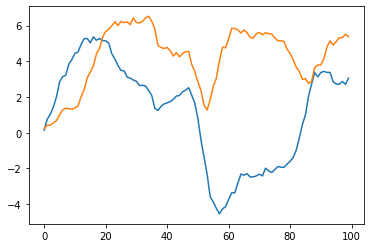

In [37]:
# see what it looks like
plt.plot(x[:100,:])

In [38]:
# get data ready to train with
train_dataset = [dict(data=x)]
test_dataset = [dict(data=x2)]
# First compute the autoregression covariates
precompute_ar_covariates(train_dataset, num_lags=num_lags, fit_intercept=True)
precompute_ar_covariates(test_dataset, num_lags=num_lags, fit_intercept=True)

# Then precompute the sufficient statistics
LinearRegressionObservations.precompute_suff_stats(train_dataset)
LinearRegressionObservations.precompute_suff_stats(test_dataset)

covariates_dim = train_dataset[0]['covariates'].shape[1]

In [39]:
# initialize model to train
config =  dict(
    num_discrete_states=2,
    data_dim=data_dim,
    covariates_dim=3,
    tau_scale=0.7,
    num_taus=3,
    kappa=100,
    alpha=0.5,
    covariance_reg=1e-4)
twarhmm = TWARHMM(config)

In [40]:
# train
train_lls, test_lls, train_posteriors, test_posteriors, = \
        twarhmm.fit_stoch(train_dataset,
                         test_dataset,
                          num_epochs=20, compute_posteriors=True, wandb_log=False)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

average iteration time:  0.11177268028259277


Text(0.5, 1.0, 'inferred discrete states')

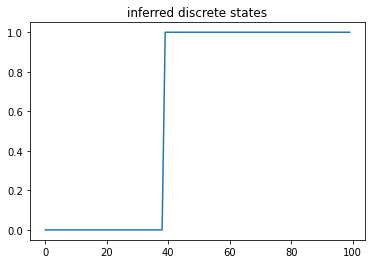

In [44]:
# get inferred discrete states via floor division by num_taus
inferred_states = test_posteriors[0].get_states()//config['num_taus']
plt.plot(inferred_states[:100])
plt.title('inferred discrete states')

Text(0.5, 1.0, 'inferred time constants')

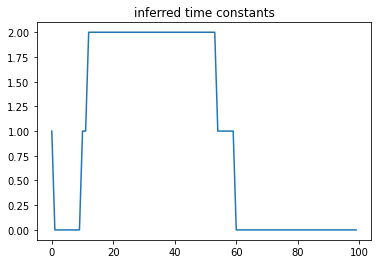

In [43]:
# get inferred taus via modding out by num_taus
inferred_taus = np.mod(test_posteriors[0].get_states(),config['num_taus'])
plt.plot(inferred_taus[:100])
plt.title('inferred time constants')